# Create Datasets for Single EEG channel Eye Blink Detector

EEG recordings are often contaminated by eye blink artifacts. When there are >25 channels (sensors), we can use techniques like Independent Component Analysis (ICA) to extract components which have eye blinks. However, this can be incredibly difficult when only a single channel is available for recording, specially if the channel is much further away from the forehead (proximity).

Here I present a semi supervised method to detect/classify epochs of data contaminated by eye blink artifacts from a single channel: Cz, that is located centrally.

Data available: 25 channels, 5 min data for 19 subjects, minimally preprocessed

File Aim: Create time series epoch datasets (training, validation, testing) and plan out classification strategy

In [1]:
#Import all libraries

import h5py

import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

from scipy.signal import welch
from signal_processing_helper import zero_phase_freq_filter, epoch_signal

from scipy.stats import zscore
from sklearn.model_selection import train_test_split

### Load EEG data of all 25 channels (5 minutes of data)
This EEG data has been notch filtered at 60Hz, high pass filtered at 0.1Hz and a common average reference (CAR) has been applied.

In [2]:
#raw data files saved as 7.3 .mat file, loading requires h5py

with h5py.File('EEGData_5min.mat', 'r') as f:
    print(list(f.keys()))

    EEGStitched = f.get('EEGStitched') # Get a certain dataset
    EEGStitched = np.array(EEGStitched)

print(EEGStitched.shape)

['EEGStitched']
(19, 29, 76800)


In [3]:
#Load information about channels and sampling rate
info_data = sio.loadmat('dataInfo.mat', chars_as_strings=True)
channel_names = info_data['channelNames'].flatten().tolist()
channel_names = [x.item() for x in channel_names]
print(channel_names)

sampling_freq = info_data['EEGSampleRate'].flatten()[0]
print(sampling_freq)

['Cz', 'Fp1', 'Fpz', 'Fp2', 'F3', 'Fz', 'F4', 'FC1', 'FC2', 'C3', 'C4', 'CP1', 'CP2', 'P3', 'Pz', 'P4', 'F1', 'F2', 'FC3', 'FCz', 'FC4', 'C1', 'C2', 'CP3', 'CPz', 'CP4', 'P1', 'P2']
256


### Plot 20 seconds of data from Fp1 (chNum 1) and Cz (chNum: 0) to visualize eye blinks
The peaks relating to eye blinks will be more obvious on Fp1 (near eyes). In Cz (center of head), the waveform will look different due to the dipole (which is causing the artifact), presents differently at that channel and the direction is the impact of CAR.

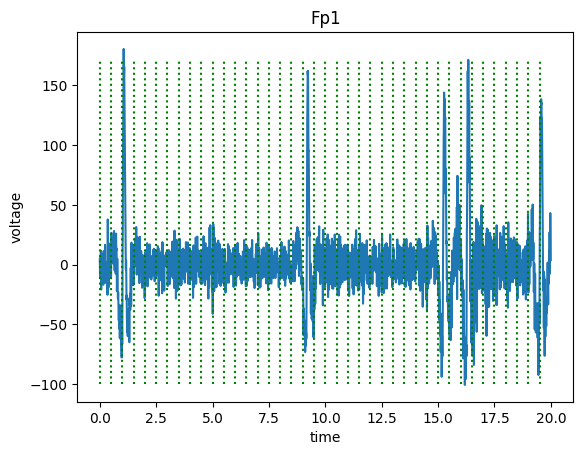

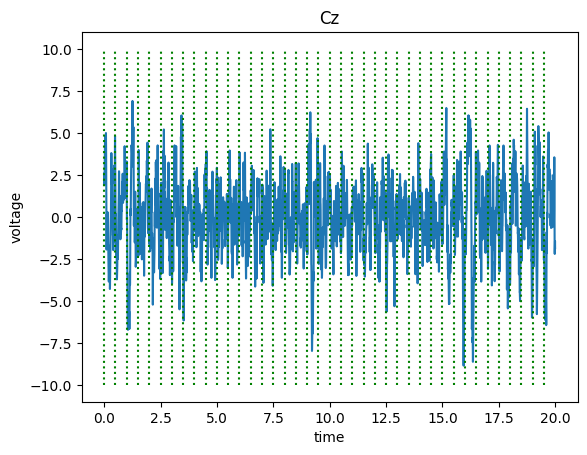

In [4]:
length = sampling_freq*20 #20 seconds of data
time_of_split = 0.5 #0.5 seconds of data (future epochs)
subjectNum = 0 #first subject

time_pts = EEGStitched[subjectNum,-1,:length] #last channel contains time in seconds

#Fp1
chNum = 1
Fp1_Data = plt.plot(time_pts,EEGStitched[subjectNum,chNum,:length])
time_vec = np.arange(0, time_pts[-1], time_of_split)

plt.ylabel( 'voltage' )
plt.xlabel( 'time' )
plt.title( channel_names[chNum]) 
ymin = -100
ymax = 170

plt.vlines(x=time_vec, ymin=ymin, ymax=ymax, colors='g', linestyles='dotted') #0.5s epochs
plt.show()

#Cz
chNum = 0
Cz_Data = plt.plot(time_pts,EEGStitched[subjectNum,chNum,:length])
time_vec = np.arange(0, time_pts[-1], time_of_split)

plt.ylabel( 'voltage' )
plt.xlabel( 'time' )
plt.title( channel_names[chNum]) 
ymin = -10
ymax = 10

plt.vlines(x=time_vec, ymin=ymin, ymax=ymax, colors='g', linestyles='dotted') #0.5s epochs
plt.show()

It is much easier to spot the eye blinks on Fp1. Much harder for a channel like Cz.

Next, we look at the frequency decomposition for Cz

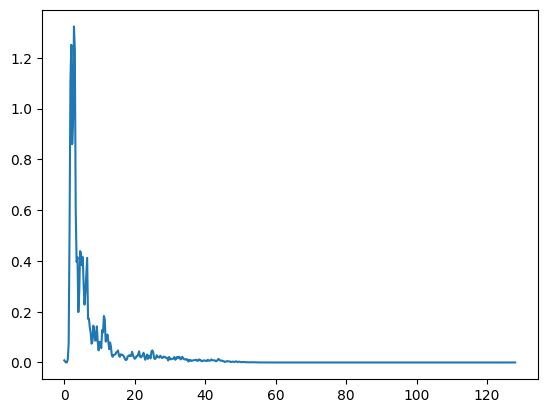

In [5]:
chNum = 0 #Cz
length = sampling_freq*20 #20 seconds of data
frequencies, psd = welch(EEGStitched[0,0,:sampling_freq*20], fs=sampling_freq, nperseg=1024)
pwelchPlot = plt.plot(frequencies, psd)

Visualizing the impact of a low pass filter on these signals

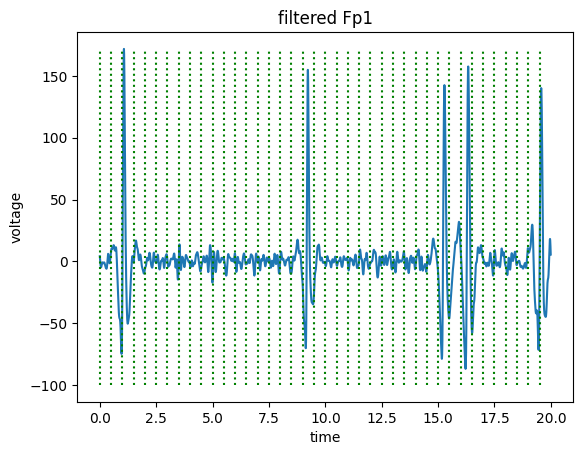

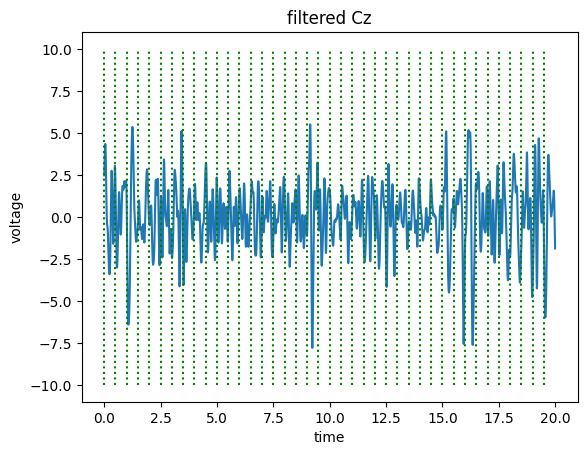

In [6]:
length = sampling_freq*20 #20 seconds of data

signalSnipCz = EEGStitched[0,0,:length]
signalSnipFp1 = EEGStitched[0,1,:length]

cutoff_freq = 10

filteredSignalSnipCz = zero_phase_freq_filter(signalSnipCz, cutoff_freq, sampling_freq, 'low', 4)
filteredSignalSnipFp1 = zero_phase_freq_filter(signalSnipFp1, cutoff_freq, sampling_freq, 'low', 4)

time_pts = EEGStitched[subjectNum,-1,:length]

Fp1_Data = plt.plot(time_pts,filteredSignalSnipFp1)
time_vec = np.arange(0, time_pts[-1], time_of_split)

chNum = 1

plt.ylabel( 'voltage' )
plt.xlabel( 'time' )
plt.title( "filtered " + channel_names[chNum]) 
ymin = -100
ymax = 170

plt.vlines(x=time_vec, ymin=ymin, ymax=ymax, colors='g', linestyles='dotted')
plt.show()

chNum = 0

Cz_Data = plt.plot(time_pts,filteredSignalSnipCz)
time_vec = np.arange(0, time_pts[-1], time_of_split)

plt.ylabel( 'voltage' )
plt.xlabel( 'time' )
plt.title( "filtered " + channel_names[chNum]) 
ymin = -10
ymax = 10

plt.vlines(x=time_vec, ymin=ymin, ymax=ymax, colors='g', linestyles='dotted')
plt.show()

Steps:
1. Break down into test, train and validation sets (3, 13, 3)
2. Epoch data
3. Label test and validation sets and a subset of training sets (3, 3, 3). Label using filtered and scaled Fp1 data

Testing data: 3/19 (labeled)
Validation data: 3/19 (labeled)
Training data: 13/19 (3 labeled)

Since Fp1 channel has more obvious blink artifacts, it will be used as a tool to label data using thresholding

In [7]:

#exracting relevant data
EEGStitchedCz = EEGStitched[:,0,:]
EEGStitchedFp1 = EEGStitched[:,1,:]

Cz_X_train, Cz_X_test, Fp1_X_train, Fp1_X_test = train_test_split(EEGStitchedCz,EEGStitchedFp1, test_size=3/19, random_state=8)
Cz_X_train, Cz_X_val, Fp1_X_train, Fp1_X_val = train_test_split(Cz_X_train,Fp1_X_train, test_size=3/16, random_state=8)
Cz_X_train_unlabeled, Cz_X_train_labeled, Fp1_X_train_unlabeled, Fp1_X_train_labeled = train_test_split(Cz_X_train,Fp1_X_train, test_size=3/13, random_state=8)


Visualizing what the Fp1 channel of the training data to be labeled looks like:
(repeated the same for testing and validation sets)

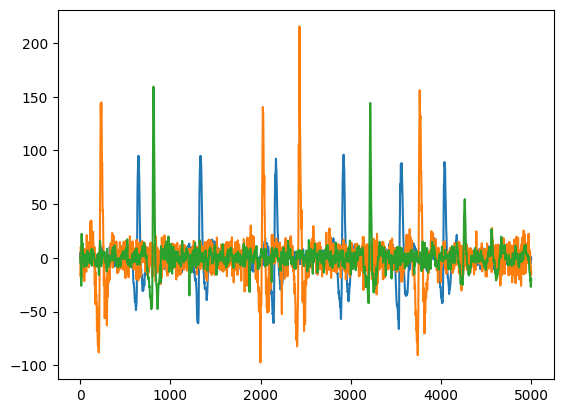

In [8]:
plt.plot(Fp1_X_train_labeled[0,:5000])
plt.plot(Fp1_X_train_labeled[1,:5000])
plt.plot(Fp1_X_train_labeled[2,:5000])

For ease of thresholding, the Fp1 data is zscore normalized and low pass filtered (3Hz) before undergoing the epoching and eventual labeling

In [9]:
#zscore normalize all data and low pass filter at 3Hz

cutoff_freq = 10

Fp1_X_train_labeled_zs = zscore(Fp1_X_train_labeled,1)
Fp1_X_train_labeled_filt = zero_phase_freq_filter(Fp1_X_train_labeled_zs, cutoff_freq, sampling_freq, 'low', 4)

Fp1_X_val_zs = zscore(Fp1_X_val,1)
Fp1_X_val_filt = zero_phase_freq_filter(Fp1_X_val_zs, cutoff_freq, sampling_freq, 'low', 4)

Fp1_X_test_zs = zscore(Fp1_X_test,1)
Fp1_X_test_filt = zero_phase_freq_filter(Fp1_X_test_zs, cutoff_freq, sampling_freq, 'low', 4)


In [10]:
epoch_length = np.int32(sampling_freq/2) #0.5 second epochs
overlap = np.int32(0) #overlap 

Cz_X_train_unlabeled_Epochs = epoch_signal(Cz_X_train_unlabeled, epoch_length, overlap) #epoch
print(Cz_X_train_unlabeled_Epochs.shape)

Cz_X_train_labeled_Epochs = epoch_signal(Cz_X_train_labeled, epoch_length, overlap) #epoch
print(Cz_X_train_labeled_Epochs.shape)
Fp1_X_train_labeled_Epochs = epoch_signal(Fp1_X_train_labeled_filt, epoch_length, overlap) 
print(Fp1_X_train_labeled_Epochs.shape)

Cz_X_val_Epochs = epoch_signal(Cz_X_val, epoch_length, overlap) 
print(Cz_X_val_Epochs.shape)
Fp1_X_val_Epochs = epoch_signal(Fp1_X_val_filt, epoch_length, overlap) 
print(Fp1_X_val_Epochs.shape)

Cz_X_test_Epochs = epoch_signal(Cz_X_test, epoch_length, overlap) 
print(Cz_X_test_Epochs.shape)
Fp1_X_test_Epochs = epoch_signal(Fp1_X_test_filt, epoch_length, overlap) 
print(Fp1_X_test_Epochs.shape)



(10, 600, 128)
(3, 600, 128)
(3, 600, 128)
(3, 600, 128)
(3, 600, 128)
(3, 600, 128)
(3, 600, 128)


Visualize the data that will be used to make labels against the concerned Cz single channel Data

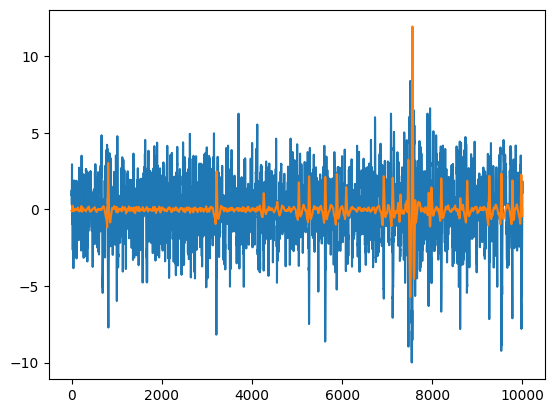

In [11]:
#labeled training set
plt.plot(Cz_X_train_labeled[2,0:10000])
plt.plot(Fp1_X_train_labeled_filt[2,0:10000])

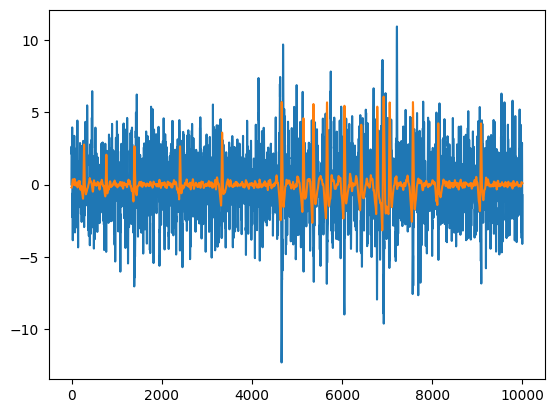

In [12]:
#validation set
plt.plot(Cz_X_val[2,0:10000])
plt.plot(Fp1_X_val_filt[2,0:10000])

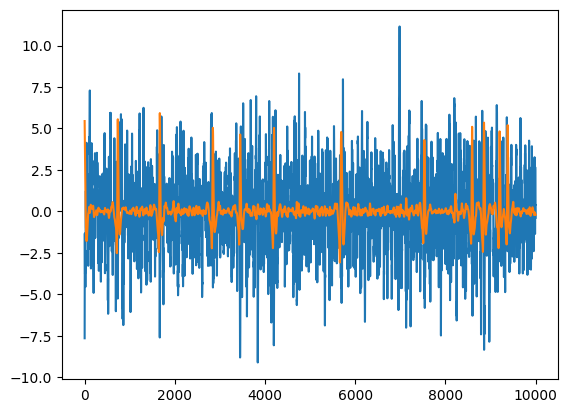

In [13]:
#validation set
plt.plot(Cz_X_test[2,0:10000])
plt.plot(Fp1_X_test_filt[2,0:10000])

Visualize an eye blink epoch: Fp1 vs Cz

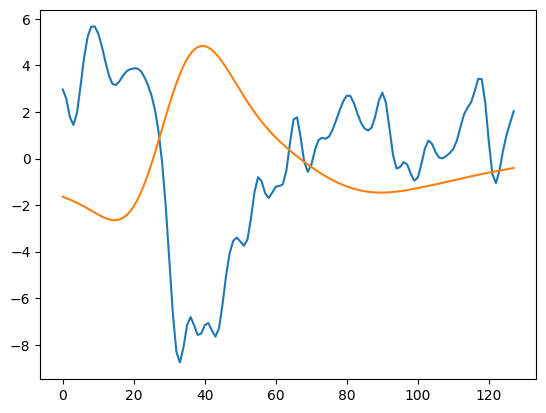

In [14]:
#plot epoch with eyeblink
plt.plot(Cz_X_val_Epochs[0,1])
plt.plot(Fp1_X_val_Epochs[0,1])

Using a threshold of 2uV to detect the epochs containing the blink artifacts

In [15]:
artifact_threshold = 2
Cz_y_val = (np.max(Fp1_X_val_Epochs, axis=2) > artifact_threshold).astype(int)
Cz_y_train_labeled = (np.max(Fp1_X_train_labeled_Epochs, axis=2) > artifact_threshold).astype(int)
Cz_y_test = (np.max(Fp1_X_test_Epochs, axis=2) > artifact_threshold).astype(int)

### Create Final Datasets of X and y values: Training, Validation and Testing
Using dataframes for ease of saving variables

In [16]:
#collapse the 3d array into 2d to create dataframes
Cz_X_train_unlabeled_df = pd.DataFrame(Cz_X_train_unlabeled_Epochs.reshape(-1, Cz_X_train_unlabeled_Epochs.shape[2]))
Cz_X_train_labeled_df = pd.DataFrame(Cz_X_train_labeled_Epochs.reshape(-1, Cz_X_train_labeled_Epochs.shape[2]))
Cz_X_val_df = pd.DataFrame(Cz_X_val_Epochs.reshape(-1, Cz_X_val_Epochs.shape[2]))
Cz_X_test_df = pd.DataFrame(Cz_X_test_Epochs.reshape(-1, Cz_X_test_Epochs.shape[2]))

Cz_y_train_labeled_df = pd.DataFrame(Cz_y_train_labeled.reshape(-1))
Cz_y_val_df = pd.DataFrame(Cz_y_val.reshape(-1))
Cz_y_test_df = pd.DataFrame(Cz_y_test.reshape(-1))
print(Cz_y_train_labeled_df.shape)

(1800, 1)


In [17]:
#Save dataframes
Cz_X_train_unlabeled_df.to_csv('Cz_X_train_unlabeled_df.csv', index=False)
Cz_X_train_labeled_df.to_csv('Cz_X_train_labeled_df.csv', index=False)
Cz_X_val_df.to_csv('Cz_X_val_df.csv', index=False)
Cz_X_test_df.to_csv('Cz_X_test_df.csv', index=False)

Cz_y_train_labeled_df.to_csv('Cz_y_train_labeled_df.csv', index=False)
Cz_y_val_df.to_csv('Cz_y_val_df.csv', index=False)
Cz_y_test_df.to_csv('Cz_y_test_df.csv', index=False)